### Plotting Function

In [86]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# FORMATTING SETTINGS
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1.3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.major.width'] = 1.3
mpl.rcParams['ytick.minor.width'] = 1

### Plotting variables ###
size = 3 ## Size of markers.
esize = 1 ## Size of error bar lines.
csize = 3 ## Size (width) of error bar caps.
cesize = 1 ## Size (height) of error bar caps.
trans = 0.07 ## Transparency (1 - opacity) of markers.
etrans= trans ## Transparency (1 - opacity) of error bars.
aesize = 0.5 ## Size of average point error bar line.
acsize = 3 ## Size (width) of average point error bar caps.
acesize = 0.5 ## Size (height) of average point error bar caps.
atrans = 1 ## Transparency (1 - opacity) of average point error bars.


def plotstart(data, x_label='x', y_label='y', dataset=[""], x_err=None, y_err=None, legend_title=None, f=None):

    colours = ["Red", "Turquoise", "Green", "Purple"]
    
    markers = [".", "s", "^"]

    plt.figure(dpi=200)
    ax = plt.axes(projection="rectilinear")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    for x in range(len(data)):

        plt.plot(data[x][0], data[x][1], ms=3, c=colours[x], marker=markers[x],
            label=dataset[x], linestyle="None")

        if x_err:
            plt.errorbar(x=data[x][0], y=data[x][1],
                            xerr=x_err[x], c=colours[x], alpha=atrans, linestyle="None", elinewidth=aesize, capsize=acsize, markeredgewidth=acesize, label=dataset[x])
        if y_err:
            plt.errorbar(x=data[x][0], y=data[x][1],
                            yerr=y_err[x], c=colours[x], alpha=atrans, linestyle="None", elinewidth=aesize, capsize=acsize, markeredgewidth=acesize, label=dataset[x])
        
    if f:
        # add a single error bar for the SFR vs Redshift for different mass bins
        plt.errorbar(x=data[1][0][f], y=data[1][1][f], yerr=0.66, c="Turquoise", alpha=atrans, linestyle="None", elinewidth=aesize, capsize=acsize, markeredgewidth=acesize)
    
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    plt.tick_params(which="both", direction='out', top=False, right=False)
    
    if len(dataset) > 1:
        plt.legend()
        if legend_title:
            plt.legend(title=legend_title)
        
    plt.show()

Import required modules and filter merged GZ + Lega-C dataset

In [2]:
import pandas as pd
import numpy as np
import scipy.linalg as sc

raw = pd.read_csv("/Users/nickmisiiuk/dev/PHYS369/data/legac+gz.csv")

low_mag = raw[(raw["ip_mag"] <= 22) & (raw["zp_mag"] <= 22)] #remove high magnitude galaxies and reduce uncertainty

gal_smooth = low_mag[low_mag["type"] == "S"]

gal_feat = low_mag[low_mag["type"] == "F"]

Import full Lega-C and filter

In [ ]:
legac = pd.read_csv("/Users/nickmisiiuk/dev/PHYS369/data/legac.csv")
legac_1 = legac[(legac["ip_mag"] <= 22) & (legac["zp_mag"] <= 22)]

#Filter anomalies
legac_final = legac_1[(legac_1["lsfr_UV"]> -2) & (legac_1["lsfr_IR"]> -2) & (legac_1["sfr_3ghz"]> 10)]

legac_final["lsfr_3ghz"] = legac_final["sfr_3ghz"].apply(np.log)

### Fitting a Linear Regression Model
Combining SFR data from UV and IR, plotting relation $A*lsfr(UV)$ + $B*lsfr(IR)$ VS SFR (radio) to determine values of A and B that produce a correlation of 1

In [ ]:
#Import required sklearn modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Define what are out model variables. We have identified that the best ones are:
x = legac_final[['lsfr_UV', 'lsfr_IR']]
# We want to predict the outcome, in this case either 0 (no claim) or 1 (claim)
y = legac_final['lsfr_3ghz']

# splitting the data into a sub-set to train and the rest to test a simple model
# Using 20% of the sample drawn up randomly multiple times to train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# creating an object of LinearRegression class
LR = LinearRegression(fit_intercept=False)
# fitting the training data and providing us with a simple model and how outcome depends linearly on the 5 parameters picked up
LR.fit(x_train,y_train)

coeffs = LR.coef_
print("A", coeffs[0])
print("B", coeffs[1])

# Get the predicted values of sfr
sfr_predicted = LR.predict(x_test)

# predicting the accuracy score
score = r2_score(y_test,sfr_predicted)

print('r^2:',score)
print('mean squared error:',mean_squared_error(y_test,sfr_predicted))
print('root mean squared error:',np.sqrt(mean_squared_error(y_test,sfr_predicted)))

Plotting the difference between the ML-predicted combined SFR and the given (radio) SFR.

In [ ]:
A = 0.10895734150002614
B = 2.45229174853243

#Create new column of combined UV + IR sfr
legac_final["lSFR_final"] = A * legac_final["lsfr_UV"] + B * legac_final["lsfr_IR"]

#Difference column
sfr_diff = legac_final["lSFR_final"] - legac_final['lsfr_3ghz']

plot_data = [[legac_final["lsfr_3ghz"], sfr_diff]]

plotstart(plot_data, y_label="lSFR_diff", x_label="lsfr_3ghz")

Plot the histogram of the calculated log(SFR) and calculate the standard deviation

In [ ]:
plt.hist(sfr_diff)
plt.show()

sfr_uncertainty = sfr_diff.std()
print("Sigma: ", sfr_diff.std())

Filter the combined GZ + Legacy dataset

In [ ]:
#Create new column of combined UV + IR sfr
low_mag["lSFR_final"] = A * low_mag["lsfr_UV"] + B * low_mag["lsfr_IR"]

#Filter anomalies
new_df = low_mag[(low_mag["lsfr_UV"]> -90) & (low_mag["lsfr_IR"]> -90)]

smooth_df = new_df[new_df["type"] == "S"]
feat_df = new_df[new_df["type"] == "F"]

### Plot of log(SFR) against Redshift for different galaxy morphologies and masses 

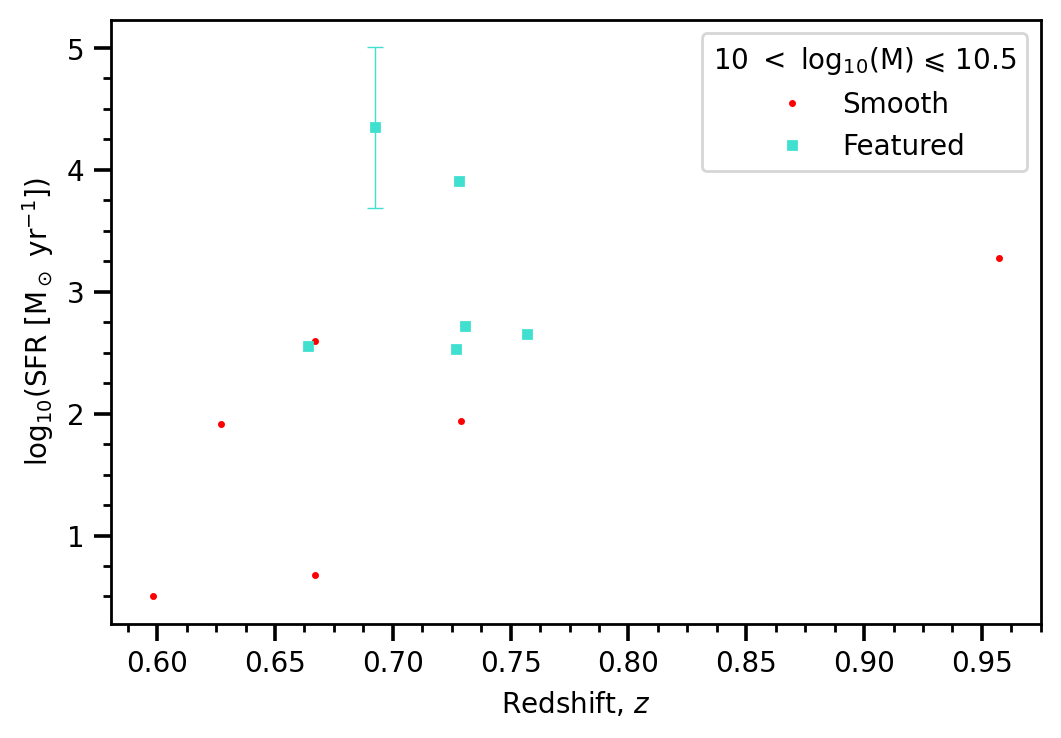

In [90]:
#Split mass into bins
smooth_m1 = smooth_df[smooth_df["fast_lmass"] <= 10.5]
smooth_m2 = smooth_df[(smooth_df["fast_lmass"] >= 10.5) & (smooth_df["fast_lmass"] <= 11)]
smooth_m3 = smooth_df[smooth_df["fast_lmass"] > 11]

feat_m1 = feat_df[feat_df["fast_lmass"] <= 10.5]
feat_m2 = feat_df[(feat_df["fast_lmass"] >= 10.5) & (feat_df["fast_lmass"] <= 11)]
feat_m3 = feat_df[feat_df["fast_lmass"] > 11]

plot_data = [[smooth_m1["z_spec"], smooth_m1["lSFR_final"]], [feat_m1["z_spec"], feat_m1["lSFR_final"]]]

plotstart(plot_data, dataset=[
          "Smooth", "Featured"], y_label="$\log_{10}(\mathrm{SFR} \ [\mathrm{M}_\odot \ \mathrm{yr}^{-1}])$", x_label="Redshift, $z$", legend_title="10 $<$ $\log_{10}$(M) $\leqslant$ 10.5", f=17)

# Task 2 -- Overdensity

1 -- Basic Plot

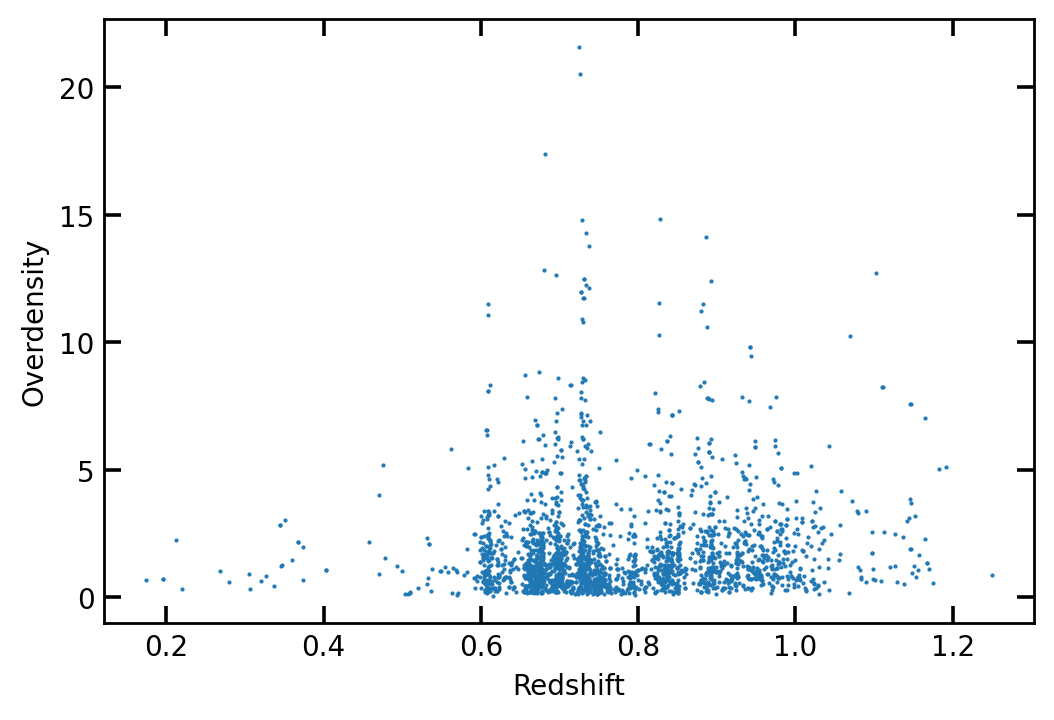

In [15]:
# Filter out anomalic overdensities
legac_overdensity = legac_1[(legac_1["darvish_overdensity"] > -90) & (legac_1["z_spec"] > -90)]

# Plot overdensity vs redshift
plt.figure(dpi=200)
ax = plt.axes()
ax.set_xlabel("Redshift")
ax.set_ylabel("Overdensity")

plt.scatter(legac_overdensity["z_spec"], legac_overdensity["darvish_overdensity"], s=1, marker='.')
plt.tick_params(which='both', direction='in', right=True, top=True)
plt.show()

2 -- **SFR vs Redshift** for different overdensity bins

/var/folders/wn/gh2cl0591kl0782h2mzq82080000gr/T/ipykernel_37707/1664939024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legac_overdensity["lSFR_final"] = A * legac_overdensity["lsfr_UV"] + B * legac_overdensity["lsfr_IR"]
/var/folders/wn/gh2cl0591kl0782h2mzq82080000gr/T/ipykernel_37707/1664939024.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  legac_overdensity["lSFR_final"] = A * legac_overdensity["lsfr_UV"] + B * legac_overdensity["lsfr_IR"]
No artists with labels found to put in legend.  Note

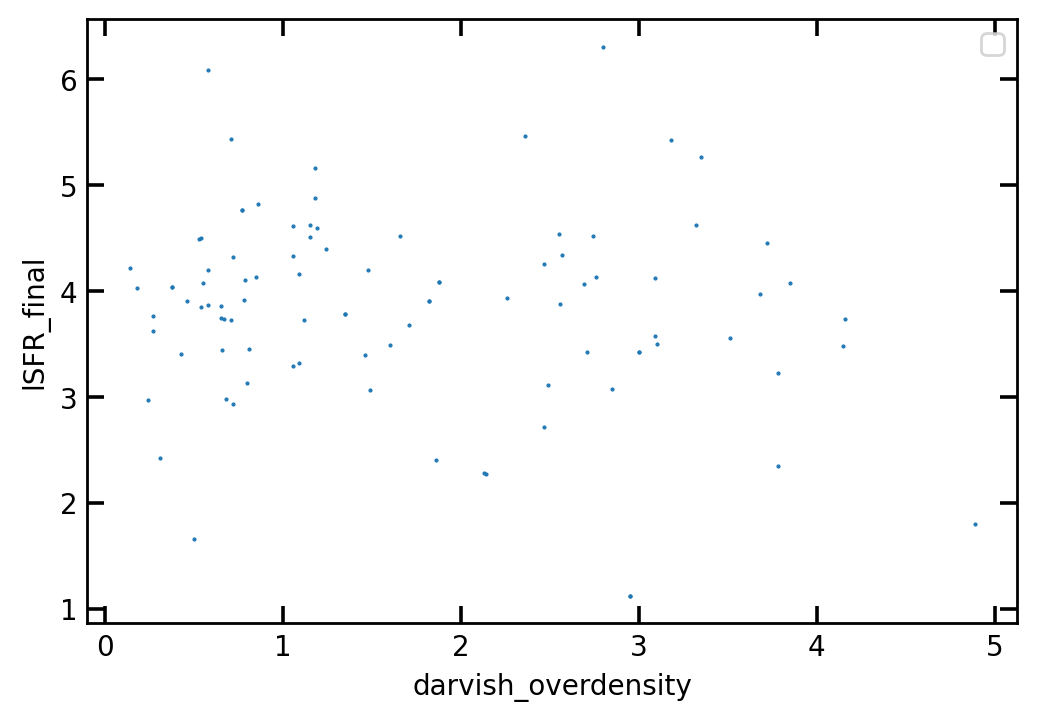

In [16]:
# New SFR column in raw legacy dataset of combined UV + IR sfr
legac_overdensity["lSFR_final"] = A * legac_overdensity["lsfr_UV"] + B * legac_overdensity["lsfr_IR"]
legac_overdensity["lSFR_final"] = A * legac_overdensity["lsfr_UV"] + B * legac_overdensity["lsfr_IR"]

legac_overdensity = legac_overdensity[(legac_overdensity["lSFR_final"] > -20) & (legac_overdensity["lSFR_final"] < 10)& (legac_overdensity["darvish_overdensity"] < 5)]

#Create different overdensity bins
legac_overdensity_1 = legac_overdensity[legac_overdensity["z_spec"] <= 0.8]
legac_overdensity_2 = legac_overdensity[(legac_overdensity["z_spec"] > 0.8) & (legac_overdensity["z_spec"] <= 1)]
legac_overdensity_3 = legac_overdensity[(legac_overdensity["z_spec"] > 1)]

#Plot SFR vs redshift
plt.figure(dpi=200)
ax = plt.axes()
ax.set_xlabel("darvish_overdensity")
ax.set_ylabel("lSFR_final")

plt.scatter(legac_overdensity_3
["darvish_overdensity"], legac_overdensity_3
["lSFR_final"], s=1, marker=".")
plt.tick_params(which='both', direction='in', right=True, top=True)
plt.legend()
plt.show()

### TEST

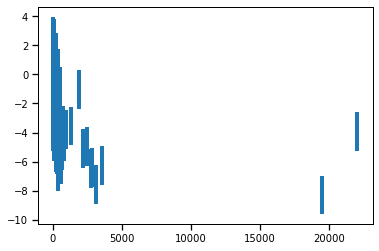

In [17]:
# plt.plot(legac_final["sfr_3ghz"], sfr_diff, marker=".", ms=2, linestyle="None")
plt.errorbar(x=legac_final["sfr_3ghz"], y=sfr_diff, yerr=sfr_uncertainty, linestyle="None", ms=1)
plt.show()